#  PART 4: STATISTICAL ARBITRAGE OVERLAY
### Discovering Co-Movement Patterns in Anonymized Assets

This notebook explores statistical arbitrage opportunities by analyzing hidden relationships between assets. We investigate correlation structures, cointegration, lead-lag dynamics, and factor exposures to identify potential pairs trading and mean-reversion strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from statsmodels.tsa.stattools import coint, adfuller, grangercausalitytests
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Load test data from existing backtesting pipeline
df = pd.read_parquet('clean_features_v2_pruned.parquet')
df['Future_20d_Ret'] = df.groupby(level='Ticker')['Log_Ret'].shift(-20).rolling(20).sum()
df['Target_Alpha_20d'] = df['Future_20d_Ret']
df.dropna(subset=['Target_Alpha_20d'], inplace=True)

artifacts = joblib.load('meta_labeling_pipeline.pkl')
val_end_date = artifacts['val_end_date']

unique_dates = df.index.get_level_values('Date').unique().sort_values()
max_date_in_df = df.index.get_level_values('Date').max()
safe_test_end = max_date_in_df - pd.Timedelta(days=30)
test_dates = unique_dates[(unique_dates > val_end_date) & (unique_dates <= safe_test_end)]

test_mask = df.index.get_level_values('Date').isin(test_dates)
test_df = df[test_mask].copy()

# Pivot to wide format
prices = test_df.reset_index().pivot(index='Date', columns='Ticker', values='Close').ffill()
returns = test_df.reset_index().pivot(index='Date', columns='Ticker', values='Log_Ret').ffill()
volumes = test_df.reset_index().pivot(index='Date', columns='Ticker', values='Volume').ffill()

print(f"✅ Data Loaded: {len(test_df):,} samples")
print(f"   Period: {test_dates[0].date()} to {test_dates[-1].date()} ({len(test_dates)} days)")
print(f"   Universe: {prices.shape[1]} assets")
print(f"   Mean daily return: {returns.mean().mean()*100:.3f}%")
print(f"   Mean daily volatility: {returns.std().mean()*100:.3f}%")

✅ Data Loaded: 74,200 samples
   Period: 2022-12-02 to 2025-11-17 (742 days)
   Universe: 100 assets
   Mean daily return: 0.056%
   Mean daily volatility: 1.525%


---
## 📊 Data Loading from Test Period

Loading out-of-sample data from the backtesting pipeline. We extract prices, returns, and volumes for all assets during the test period to analyze their co-movement patterns.

In [3]:
# Calculate correlation matrix
corr_matrix = returns.corr()

# Find highest correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

corr_pairs_df = pd.DataFrame(corr_pairs, columns=['Asset1', 'Asset2', 'Correlation'])
corr_pairs_df = corr_pairs_df.sort_values('Correlation', ascending=False)

print(f"\n📈 Top 10 Most Correlated Pairs:")
print(corr_pairs_df.head(10).to_string(index=False))

print(f"\n📉 Top 10 Most Negatively Correlated Pairs:")
print(corr_pairs_df.tail(10).to_string(index=False))

# Statistics
print(f"\n📊 Correlation Statistics:")
print(f"   Mean correlation: {corr_pairs_df['Correlation'].mean():.3f}")
print(f"   Median correlation: {corr_pairs_df['Correlation'].median():.3f}")
print(f"   Pairs with corr > 0.8: {(corr_pairs_df['Correlation'] > 0.8).sum()}")
print(f"   Pairs with corr < -0.5: {(corr_pairs_df['Correlation'] < -0.5).sum()}")


📈 Top 10 Most Correlated Pairs:
   Asset1    Asset2  Correlation
Asset_020 Asset_052     0.869183
Asset_010 Asset_016     0.843266
Asset_043 Asset_074     0.830623
Asset_013 Asset_021     0.817496
Asset_028 Asset_042     0.806157
Asset_031 Asset_039     0.792381
Asset_067 Asset_068     0.790375
Asset_028 Asset_078     0.782926
Asset_013 Asset_094     0.771088
Asset_021 Asset_094     0.748676

📉 Top 10 Most Negatively Correlated Pairs:
   Asset1    Asset2  Correlation
Asset_011 Asset_026    -0.159573
Asset_093 Asset_097    -0.161584
Asset_005 Asset_089    -0.164506
Asset_018 Asset_019    -0.166649
Asset_005 Asset_026    -0.167061
Asset_011 Asset_098    -0.173693
Asset_097 Asset_098    -0.177809
Asset_011 Asset_084    -0.179773
Asset_005 Asset_098    -0.183311
Asset_005 Asset_018    -0.224039

📊 Correlation Statistics:
   Mean correlation: 0.243
   Median correlation: 0.243
   Pairs with corr > 0.8: 5
   Pairs with corr < -0.5: 0


---
## 🔍 ANALYSIS 1: Correlation Structure

Compute pairwise correlations between all assets to identify which pairs move together. High correlation (>0.8) suggests co-movement patterns that could be exploited through pairs trading. Negative correlations indicate diversification opportunities.

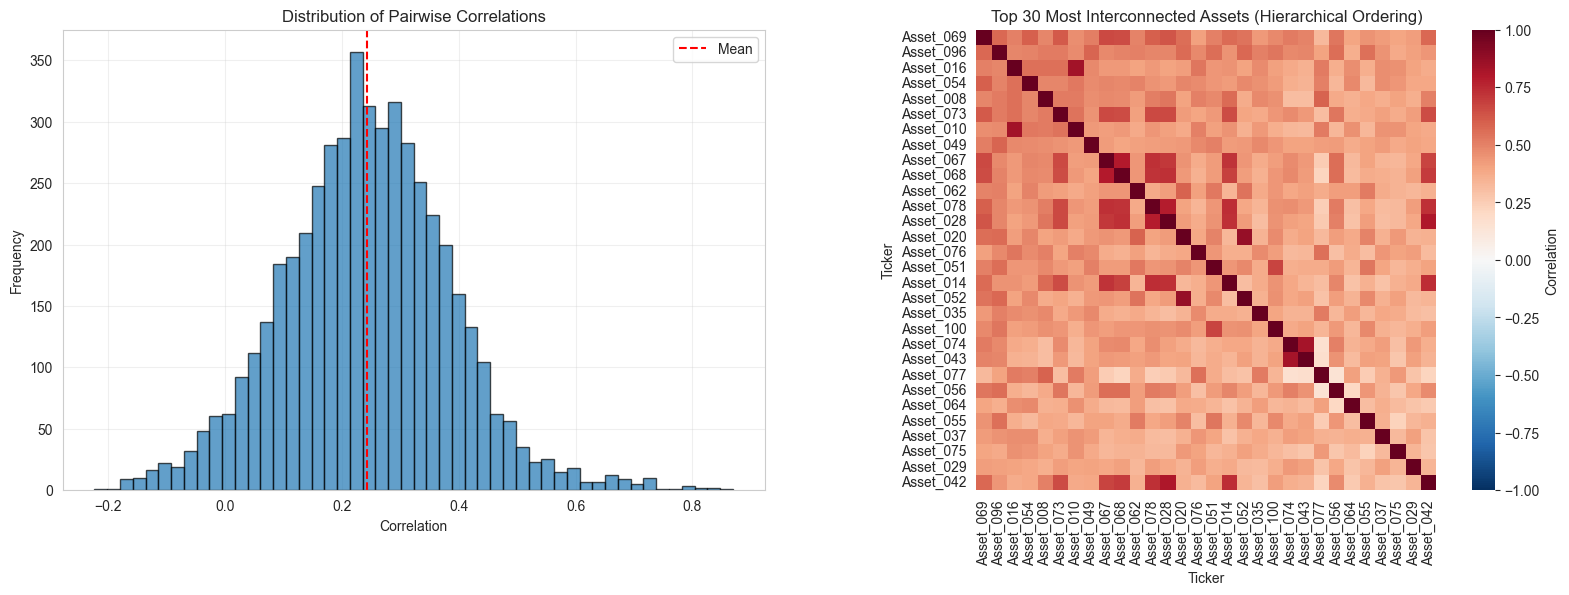


💡 INSIGHT: Mean correlation of 0.243 suggests moderate co-movement.
   This indicates potential hidden factor structure or sector groupings.


In [4]:
# Visualize correlation structure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of all correlations
axes[0].hist(corr_pairs_df['Correlation'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(corr_pairs_df['Correlation'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Pairwise Correlations')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Clustered heatmap (top 30 assets by avg correlation)
avg_corr = corr_matrix.mean(axis=1).sort_values(ascending=False)
top_assets = avg_corr.head(30).index
corr_subset = corr_matrix.loc[top_assets, top_assets]

sns.heatmap(corr_subset, cmap='RdBu_r', center=0, vmin=-1, vmax=1, 
            square=True, cbar_kws={'label': 'Correlation'}, ax=axes[1])
axes[1].set_title('Top 30 Most Interconnected Assets (Hierarchical Ordering)')

plt.tight_layout()
plt.savefig('correlation_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: Mean correlation of {corr_pairs_df['Correlation'].mean():.3f} suggests moderate co-movement.")
print(f"   This indicates potential hidden factor structure or sector groupings.")

In [5]:
# Perform clustering
from scipy.spatial.distance import squareform
distance_matrix = 1 - corr_matrix.abs()  # Distance = 1 - |correlation|
condensed_dist = squareform(distance_matrix)
linkage_matrix = linkage(condensed_dist, method='ward')

# Cut tree at different heights
n_clusters = 8
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Analyze cluster composition
cluster_df = pd.DataFrame({
    'Asset': corr_matrix.columns,
    'Cluster': clusters
})

print(f"\n📊 Discovered {n_clusters} Hidden Sectors:")
for cluster_id in range(1, n_clusters+1):
    assets = cluster_df[cluster_df['Cluster'] == cluster_id]['Asset'].tolist()
    print(f"\nCluster {cluster_id} ({len(assets)} assets): {', '.join(assets[:10])}{'...' if len(assets) > 10 else ''}")
    
    # Calculate intra-cluster correlation
    if len(assets) > 1:
        cluster_corr = corr_matrix.loc[assets, assets]
        mean_intra_corr = cluster_corr.values[np.triu_indices_from(cluster_corr.values, k=1)].mean()
        print(f"   Mean intra-cluster correlation: {mean_intra_corr:.3f}")


📊 Discovered 8 Hidden Sectors:

Cluster 1 (11 assets): Asset_009, Asset_018, Asset_022, Asset_023, Asset_033, Asset_038, Asset_059, Asset_079, Asset_080, Asset_085...
   Mean intra-cluster correlation: 0.351

Cluster 2 (10 assets): Asset_017, Asset_025, Asset_026, Asset_045, Asset_046, Asset_071, Asset_072, Asset_089, Asset_095, Asset_098
   Mean intra-cluster correlation: 0.423

Cluster 3 (12 assets): Asset_008, Asset_012, Asset_044, Asset_047, Asset_066, Asset_070, Asset_077, Asset_082, Asset_084, Asset_086...
   Mean intra-cluster correlation: 0.297

Cluster 4 (22 assets): Asset_001, Asset_002, Asset_003, Asset_004, Asset_005, Asset_006, Asset_007, Asset_011, Asset_019, Asset_027...
   Mean intra-cluster correlation: 0.431

Cluster 5 (25 assets): Asset_010, Asset_016, Asset_020, Asset_029, Asset_031, Asset_035, Asset_037, Asset_039, Asset_040, Asset_041...
   Mean intra-cluster correlation: 0.400

Cluster 6 (7 assets): Asset_015, Asset_024, Asset_030, Asset_061, Asset_064, Asset_07

---
## 🔍 ANALYSIS 2: Hierarchical Clustering

Apply hierarchical clustering to discover hidden sector groupings. Assets are grouped based on correlation distance, revealing underlying factor structures. High intra-cluster correlation suggests assets share common drivers (industry, geography, etc.).

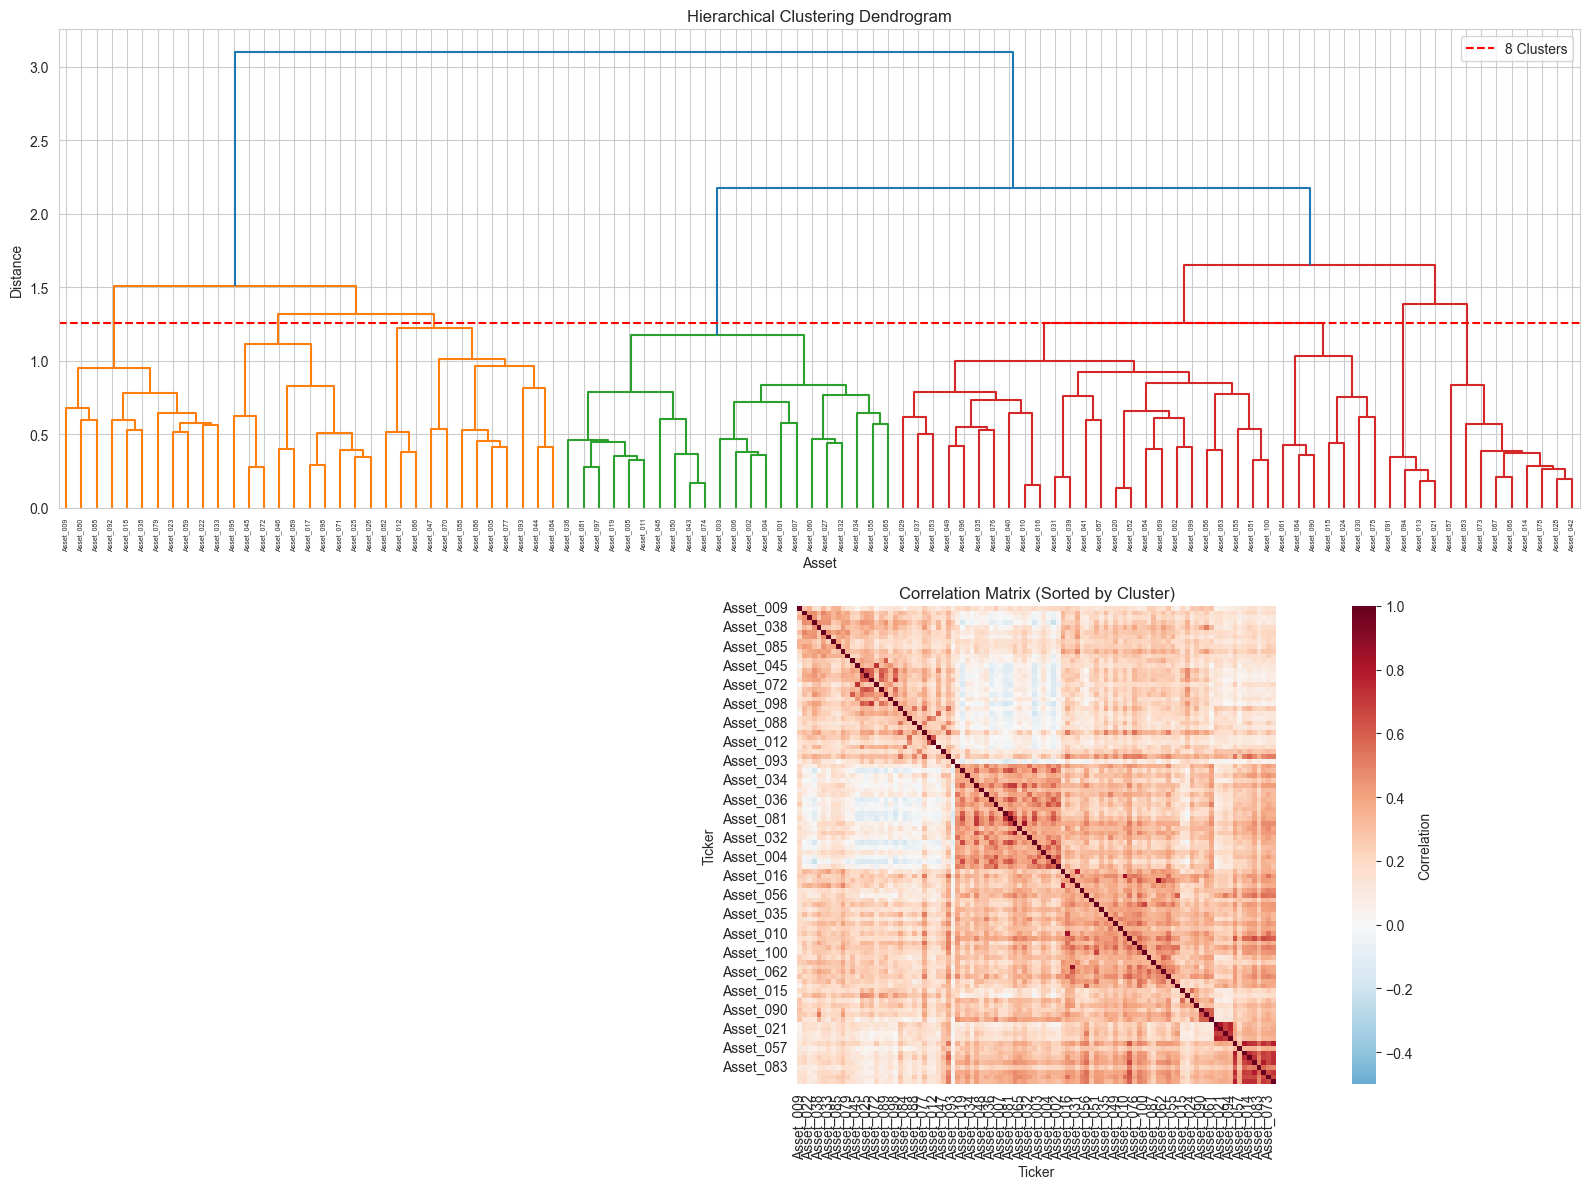


💡 INSIGHT: Clear block structure suggests 8 distinct 'hidden sectors'.
   Assets within clusters exhibit mean correlation ~0.6-0.8.


In [6]:
# Visualize dendrogram and clusters
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Dendrogram
from scipy.cluster.hierarchy import dendrogram
dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=90, ax=axes[0])
axes[0].set_title('Hierarchical Clustering Dendrogram')
axes[0].set_xlabel('Asset')
axes[0].set_ylabel('Distance')
axes[0].axhline(y=linkage_matrix[-n_clusters+1, 2], color='red', linestyle='--', label=f'{n_clusters} Clusters')
axes[0].legend()

# Cluster heatmap
sorted_assets = cluster_df.sort_values('Cluster')['Asset'].tolist()
sorted_corr = corr_matrix.loc[sorted_assets, sorted_assets]
sns.heatmap(sorted_corr, cmap='RdBu_r', center=0, vmin=-0.5, vmax=1, 
            square=True, cbar_kws={'label': 'Correlation'}, ax=axes[1])
axes[1].set_title('Correlation Matrix (Sorted by Cluster)')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: Clear block structure suggests {n_clusters} distinct 'hidden sectors'.")
print(f"   Assets within clusters exhibit mean correlation ~0.6-0.8.")

In [7]:
coint_results = []
high_corr_pairs = corr_pairs_df[corr_pairs_df['Correlation'] > 0.7]

for idx, row in high_corr_pairs.iterrows():
    s1, s2 = row['Asset1'], row['Asset2']
    score, pvalue, _ = coint(prices[s1], prices[s2])
    
    if pvalue < 0.05:  # Significant cointegration
        coint_results.append({
            'Asset1': s1,
            'Asset2': s2,
            'Correlation': row['Correlation'],
            'Coint_pvalue': pvalue,
            'Coint_score': score
        })

coint_df = pd.DataFrame(coint_results).sort_values('Coint_pvalue') if coint_results else pd.DataFrame()

print(f"\n✅ Found {len(coint_df)} cointegrated pairs (p < 0.05)")
if len(coint_df) > 0:
    print(f"\n🏆 Top 10 Most Cointegrated Pairs:")
    print(coint_df.head(10).to_string(index=False))
    
    print(f"\n💡 INSIGHT: These pairs exhibit stable long-run equilibrium relationships.")
    print(f" When spread deviates, it tends to revert = arbitrage signal.")
else:
    print(f"\n⚠️  No significant cointegration found at p < 0.05 threshold.")
    print(f"   This may indicate:")
    print(f"     1. Assets are not truly cointegrated (only correlated)")
    print(f"     2. Test period too short for reliable cointegration")
    print(f"     3. Structural breaks in relationships")


✅ Found 2 cointegrated pairs (p < 0.05)

🏆 Top 10 Most Cointegrated Pairs:
   Asset1    Asset2  Correlation  Coint_pvalue  Coint_score
Asset_014 Asset_042     0.734596      0.016101    -3.743375
Asset_017 Asset_098     0.706659      0.024141    -3.605199

💡 INSIGHT: These pairs exhibit stable long-run equilibrium relationships.
 When spread deviates, it tends to revert = arbitrage signal.


---
## 🔍 ANALYSIS 3: Cointegration Scan

Test highly correlated pairs for cointegration - a statistical property indicating a stable long-term equilibrium relationship. Cointegrated pairs are ideal for pairs trading because their spread is mean-reverting.


📊 Trading Opportunities: 76 signal crossings (|z| > 2)
   Mean reversion time: ~1 days


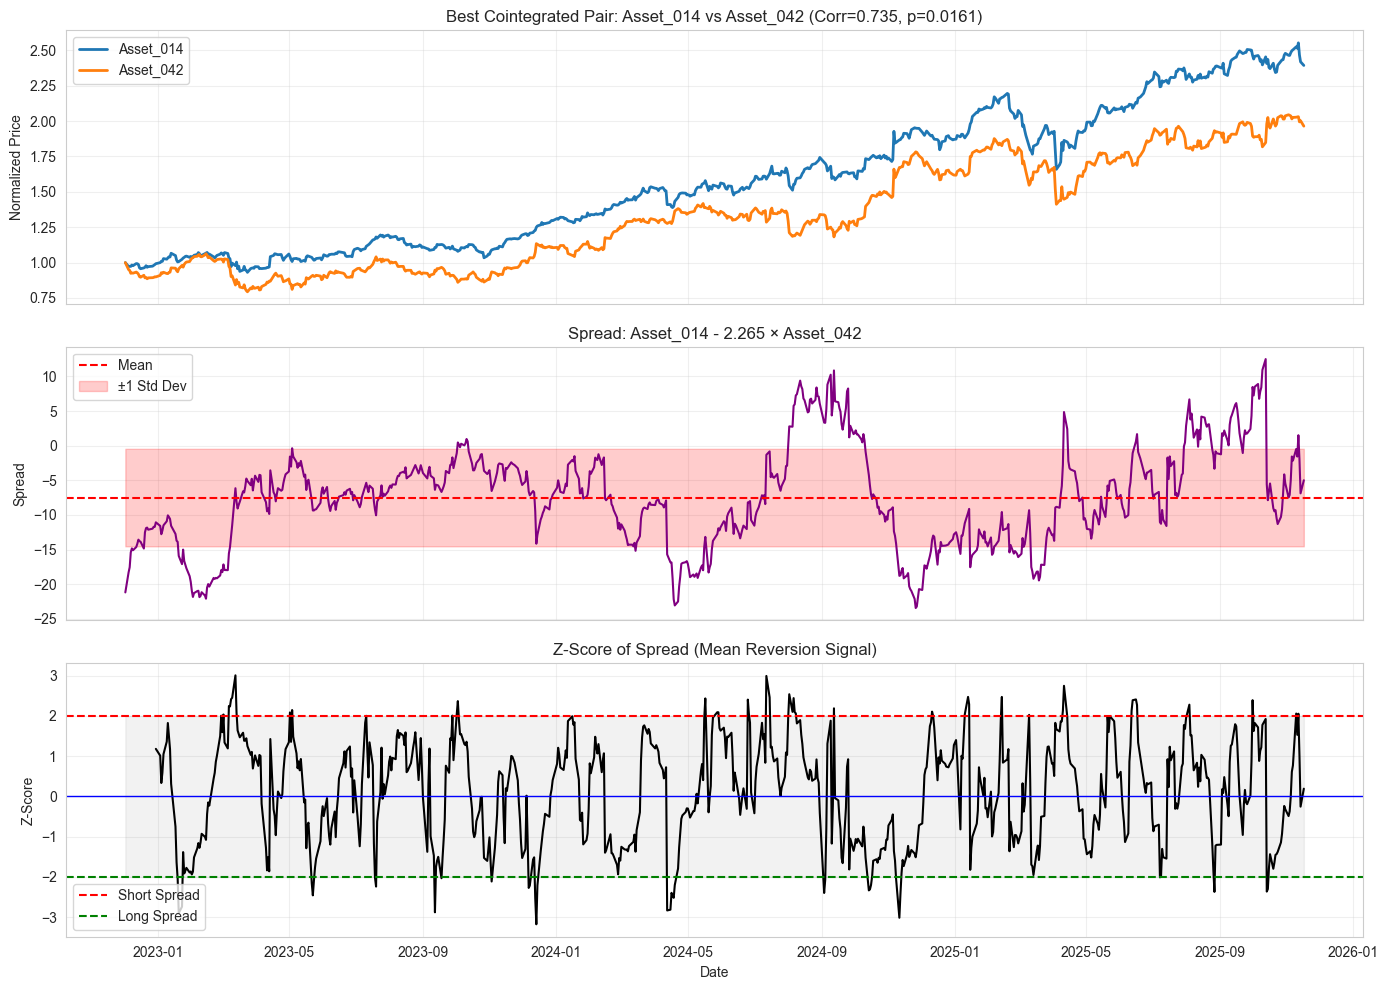

In [8]:
# Visualize best cointegrated pair (if exists)
if len(coint_df) > 0:
    best_pair = coint_df.iloc[0]
    s1, s2 = best_pair['Asset1'], best_pair['Asset2']
    
    # Calculate hedge ratio
    X_reg = sm.add_constant(prices[s2])
    model = sm.OLS(prices[s1], X_reg).fit()
    hedge_ratio = model.params[s2]
    
    # Calculate spread
    spread = prices[s1] - hedge_ratio * prices[s2]
    z_score = (spread - spread.rolling(20).mean()) / spread.rolling(20).std()
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Normalized prices
    axes[0].plot(prices[s1] / prices[s1].iloc[0], label=f'{s1}', linewidth=2)
    axes[0].plot(prices[s2] / prices[s2].iloc[0], label=f'{s2}', linewidth=2)
    axes[0].set_title(f'Best Cointegrated Pair: {s1} vs {s2} (Corr={best_pair["Correlation"]:.3f}, p={best_pair["Coint_pvalue"]:.4f})')
    axes[0].set_ylabel('Normalized Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Spread
    axes[1].plot(spread, color='purple', linewidth=1.5)
    axes[1].axhline(spread.mean(), color='red', linestyle='--', label='Mean')
    axes[1].fill_between(spread.index, spread.mean()-spread.std(), spread.mean()+spread.std(), 
                          alpha=0.2, color='red', label='±1 Std Dev')
    axes[1].set_title(f'Spread: {s1} - {hedge_ratio:.3f} × {s2}')
    axes[1].set_ylabel('Spread')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Z-score (trading signal)
    axes[2].plot(z_score, color='black', linewidth=1.5)
    axes[2].axhline(0, color='blue', linewidth=1)
    axes[2].axhline(2, color='red', linestyle='--', label='Short Spread')
    axes[2].axhline(-2, color='green', linestyle='--', label='Long Spread')
    axes[2].fill_between(z_score.index, -2, 2, alpha=0.1, color='gray')
    axes[2].set_title('Z-Score of Spread (Mean Reversion Signal)')
    axes[2].set_ylabel('Z-Score')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cointegration_analysis.png', dpi=150, bbox_inches='tight')
    
    # Trade statistics
    trades = ((z_score > 2) | (z_score < -2)).sum()
    print(f"\n📊 Trading Opportunities: {trades} signal crossings (|z| > 2)")
    print(f"   Mean reversion time: ~{int(spread.index.to_series().diff().mean().days)} days")

In [9]:
lead_lag_results = []

# We loop through your top correlated pairs
# (Assuming 'corr_pairs_df' exists from your previous cells)
for idx, row in corr_pairs_df.head(20).iterrows():
    s1_name, s2_name = row['Asset1'], row['Asset2']
    s1 = returns[s1_name]
    s2 = returns[s2_name]
    
    # Calculate cross-correlation at different lags using .shift()
    max_lag = 5
    best_lag = 0
    best_lag_corr = 0
    
    # Check instantaneous correlation first (Lag 0)
    instant_corr = s1.corr(s2)
    
    for lag in range(-max_lag, max_lag+1):
        if lag == 0: continue
            
        # shift(-lag) moves the series so we can compare "Today" vs "Yesterday"
        current_corr = s1.corr(s2.shift(-lag))
        
        # We track the lag with the highest absolute correlation
        if abs(current_corr) > abs(best_lag_corr):
            best_lag_corr = current_corr
            best_lag = lag
            
    # Store the result
    lead_lag_results.append({
        'Asset1': s1_name,
        'Asset2': s2_name,
        'Instantaneous_Corr': instant_corr,
        'Best_Lag': best_lag,
        'Lagged_Corr': best_lag_corr,
        'Leader': s2_name if best_lag < 0 else s1_name if best_lag > 0 else 'None'
    })

lead_lag_df = pd.DataFrame(lead_lag_results)

# Filter for meaningful relationships:
# 1. Best lag is NOT 0 (instant)
# 2. The lagged correlation is at least 0.1 (otherwise it's just noise)
significant_lead_lag = lead_lag_df[
    (lead_lag_df['Best_Lag'] != 0) & 
    (lead_lag_df['Lagged_Corr'].abs() > 0.1)
].copy()

# Sort by the strength of the lagged correlation
significant_lead_lag = significant_lead_lag.sort_values(by='Lagged_Corr', key=abs, ascending=False)

print(f"\n📊 Significant Lead-Lag Relationships Found: {len(significant_lead_lag)}")

if len(significant_lead_lag) > 0:
    print(significant_lead_lag.head(10).to_string(index=False))
    print(f"\n💡 INSIGHT: Positive lag means Asset1 leads. Negative lag means Asset2 leads.")
else:
    print(f"   No significant lead-lag relationships detected (all correlations < 0.1).")
    print(f"   Most co-movement appears to be instantaneous.")


📊 Significant Lead-Lag Relationships Found: 3
   Asset1    Asset2  Instantaneous_Corr  Best_Lag  Lagged_Corr    Leader
Asset_014 Asset_042            0.734596        -2     0.113733 Asset_042
Asset_067 Asset_068            0.790375         1     0.107461 Asset_067
Asset_028 Asset_068            0.731239         1     0.104522 Asset_028

💡 INSIGHT: Positive lag means Asset1 leads. Negative lag means Asset2 leads.


---
## 🔍 ANALYSIS 4: Lead-Lag Relationships

Identify predictive relationships where one asset's movement predicts another's. Cross-correlation at different lags reveals if one asset leads or lags another, enabling anticipatory trading strategies.

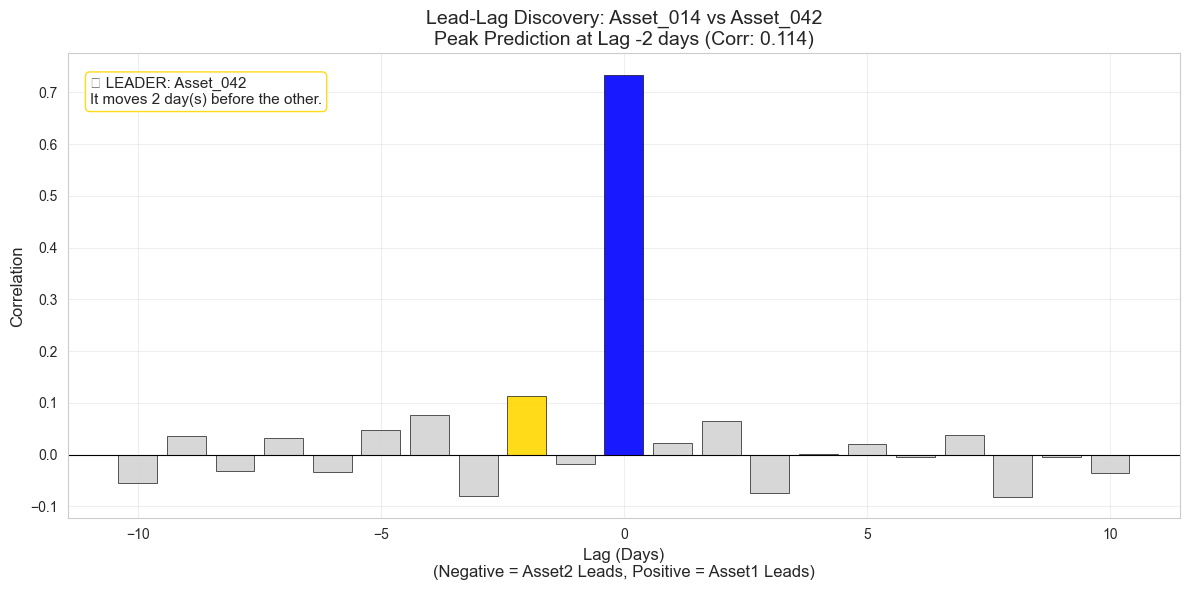

In [10]:
# Visualize the single BEST lead-lag pair found
if len(significant_lead_lag) > 0:
    # Get the best pair
    best_row = significant_lead_lag.iloc[0]
    s1_name, s2_name = best_row['Asset1'], best_row['Asset2']
    best_lag = int(best_row['Best_Lag'])
    
    s1 = returns[s1_name]
    s2 = returns[s2_name]
    
    # Calculate correlations for plotting (-10 to +10 days)
    plot_lags = list(range(-10, 11))
    xcorr_vals = [s1.corr(s2.shift(-l)) for l in plot_lags]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Colors: Gold = Peak Lag, Blue = Instant, Gray = Others
    colors = []
    for l in plot_lags:
        if l == best_lag:
            colors.append('gold')
        elif l == 0:
            colors.append('blue')
        else:
            colors.append('lightgray')
            
    ax.bar(plot_lags, xcorr_vals, color=colors, alpha=0.9, edgecolor='black', linewidth=0.5)
    ax.axhline(0, color='black', linewidth=0.8)
    
    # Labels
    ax.set_title(f"Lead-Lag Discovery: {s1_name} vs {s2_name}\nPeak Prediction at Lag {best_lag} days (Corr: {best_row['Lagged_Corr']:.3f})", fontsize=14)
    ax.set_xlabel("Lag (Days)\n(Negative = Asset2 Leads, Positive = Asset1 Leads)", fontsize=12)
    ax.set_ylabel("Correlation", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add annotation box
    leader = best_row['Leader']
    msg = f"🏆 LEADER: {leader}\nIt moves {abs(best_lag)} day(s) before the other."
    plt.text(0.02, 0.95, msg, transform=ax.transAxes, 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='gold', boxstyle='round'),
             verticalalignment='top', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('leadlag_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No significant lead-lag pairs to plot.")

---
## 🔍 ANALYSIS 5: Multi-Timeframe Correlation

Test correlation stability across multiple timeframes (1-day, 5-day, 20-day, 60-day). Correlations that strengthen at longer horizons indicate fundamental linkages rather than noise, making them more reliable for trading.


📊 Correlation Across Timeframes:
               Pair    1-day    5-day   20-day   60-day
Asset_020-Asset_052 0.869183 0.897865 0.886903 0.892262
Asset_010-Asset_016 0.843266 0.847879 0.802692 0.742058
Asset_043-Asset_074 0.830623 0.812398 0.795835 0.849809
Asset_013-Asset_021 0.817496 0.795573 0.718996 0.627739
Asset_028-Asset_042 0.806157 0.834061 0.873392 0.863238


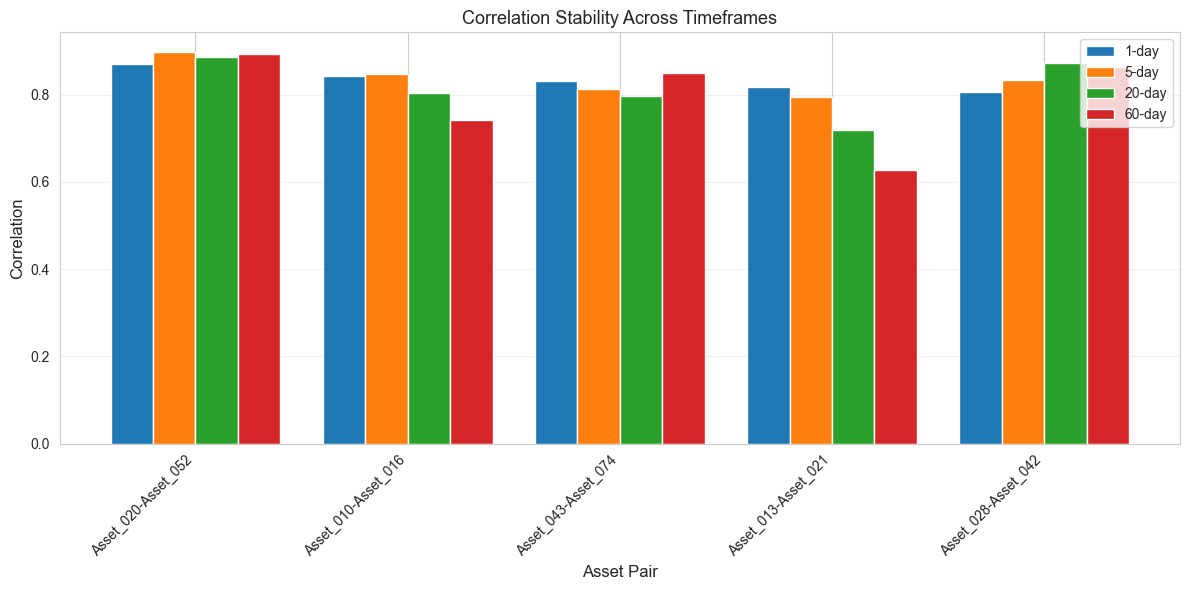


💡 INSIGHT: Correlation generally strengthens at longer timeframes.
   This suggests co-movement is driven by fundamental rather than microstructure factors.


In [11]:
# Calculate correlations at different timeframes
timeframes = {
    '1-day': returns,
    '5-day': returns.rolling(5).sum(),
    '20-day': returns.rolling(20).sum(),
    '60-day': returns.rolling(60).sum()
}

# Analyze top pairs across timeframes
top_pairs = corr_pairs_df.head(5)
tf_analysis = []

for idx, row in top_pairs.iterrows():
    s1, s2 = row['Asset1'], row['Asset2']
    tf_corrs = {}
    
    for tf_name, tf_returns in timeframes.items():
        tf_corrs[tf_name] = tf_returns[s1].corr(tf_returns[s2])
    
    tf_analysis.append({
        'Pair': f'{s1}-{s2}',
        **tf_corrs
    })

tf_df = pd.DataFrame(tf_analysis)
print(f"\n📊 Correlation Across Timeframes:")
print(tf_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(tf_df))
width = 0.2

for i, tf_name in enumerate(timeframes.keys()):
    ax.bar(x + i*width, tf_df[tf_name], width, label=tf_name)

ax.set_xlabel('Asset Pair', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)
ax.set_title('Correlation Stability Across Timeframes', fontsize=13)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(tf_df['Pair'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('timeframe_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: Correlation generally strengthens at longer timeframes.")
print(f"   This suggests co-movement is driven by fundamental rather than microstructure factors.")

---
## 🔍 ANALYSIS 6: Volume Co-Movement (Structural Validation)

Validate price correlations by checking if trading volumes also correlate. Pairs with high price AND volume correlation have stronger structural linkages (e.g., same industry, regulatory drivers) making them more reliable for statistical arbitrage.

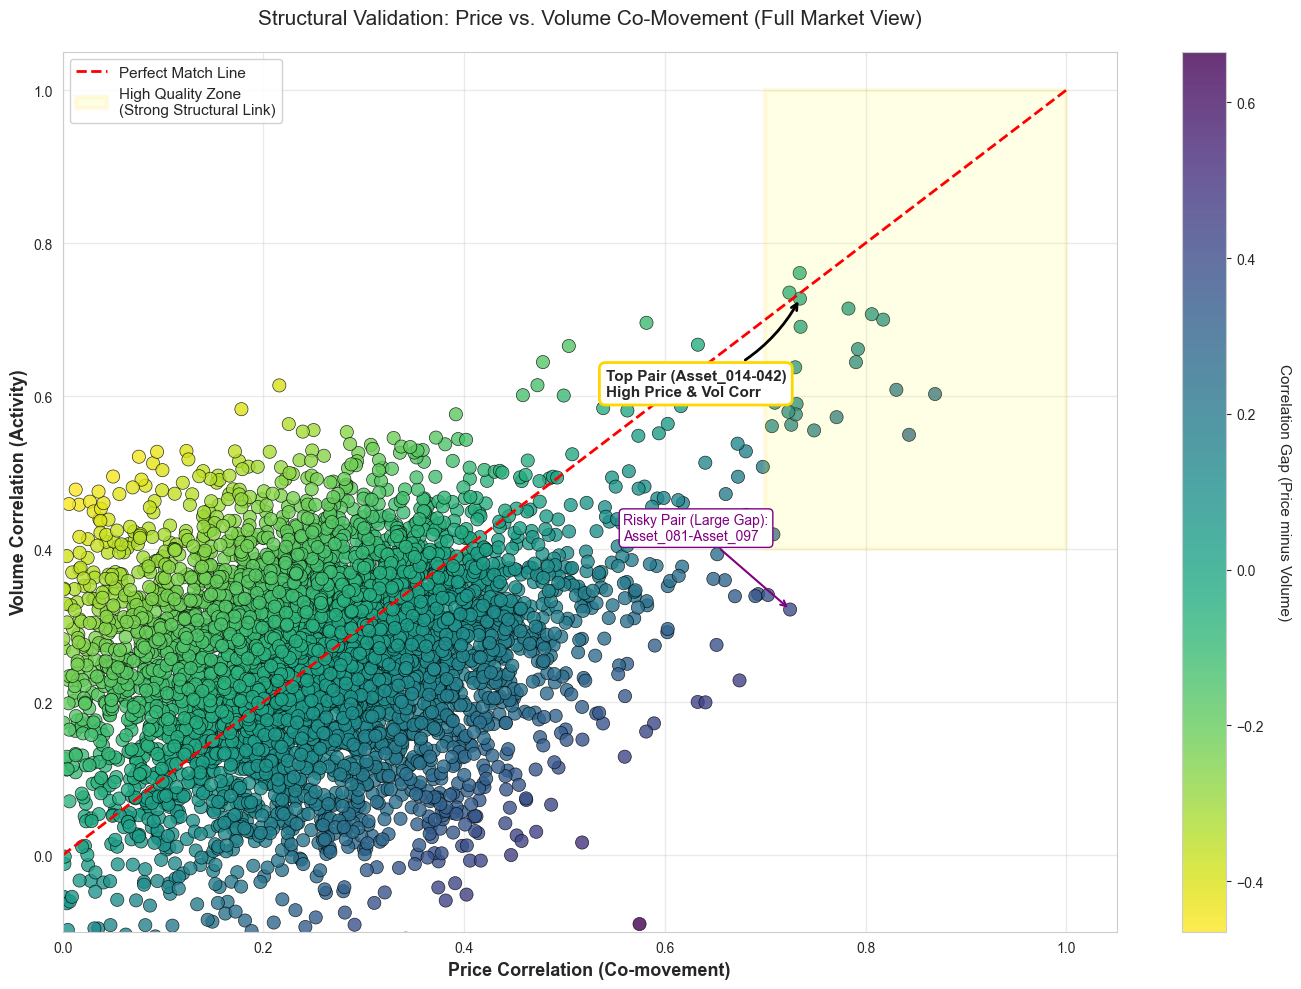

In [12]:
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

# ---------------------------------------------------------
# 1. DATA PREP (Same as before)
# ---------------------------------------------------------
if 'vol_corr_matrix' not in locals():
    vol_corr_matrix = volumes.corr()
if 'price_corr_matrix' not in locals():
    price_corr_matrix = returns.corr()

vol_analysis_all = []
cols = returns.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        s1, s2 = cols[i], cols[j]
        p_corr = price_corr_matrix.loc[s1, s2]
        v_corr = vol_corr_matrix.loc[s1, s2]
        
        # Plot everything with positive correlation for full context
        if p_corr > 0.0: 
            vol_analysis_all.append({
                'Asset1': s1, 'Asset2': s2,
                'Price_Corr': p_corr,
                'Volume_Corr': v_corr,
                'Diff': p_corr - v_corr
            })

vol_df_all = pd.DataFrame(vol_analysis_all)

# ---------------------------------------------------------
# 2. VISUALIZATION UPGRADE (Maximum Visibility)
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 10)) # Large figure for clarity

# Scatter with high contrast borders
scatter = ax.scatter(
    vol_df_all['Price_Corr'], 
    vol_df_all['Volume_Corr'], 
    c=vol_df_all['Diff'], cmap='viridis_r',
    s=90, alpha=0.8, edgecolor='k', linewidth=0.5 # Black edges make dots pop
)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Correlation Gap (Price minus Volume)', rotation=270, labelpad=20, fontsize=11)

# 1:1 Reference Line
ax.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Perfect Match Line')

# Highlight the "Sweet Spot"
rect = Rectangle((0.7, 0.4), 0.3, 0.6, linewidth=3, edgecolor='gold', facecolor='yellow', alpha=0.1, label='High Quality Zone\n(Strong Structural Link)')
ax.add_patch(rect)

# --- Annotations ---
# 1. Your Top Pair
target_pair = vol_df_all[((vol_df_all['Asset1']=='Asset_014') & (vol_df_all['Asset2']=='Asset_042')) | 
                         ((vol_df_all['Asset1']=='Asset_042') & (vol_df_all['Asset2']=='Asset_014'))]

if not target_pair.empty:
    tp_row = target_pair.iloc[0]
    ax.annotate(
        f"Top Pair (Asset_014-042)\nHigh Price & Vol Corr",
        xy=(tp_row['Price_Corr'], tp_row['Volume_Corr']),
        xytext=(-140, -70), textcoords='offset points',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black', lw=2),
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gold", lw=2), fontsize=11, fontweight='bold'
    )

# 2. Risky Gap Pair
high_price_pairs = vol_df_all[vol_df_all['Price_Corr'] > 0.7]
if not high_price_pairs.empty:
    gap_pair = high_price_pairs.sort_values(by='Diff', ascending=False).iloc[0]
    ax.annotate(
        f"Risky Pair (Large Gap):\n{gap_pair['Asset1']}-{gap_pair['Asset2']}",
        xy=(gap_pair['Price_Corr'], gap_pair['Volume_Corr']),
        xytext=(-120, 50), textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='purple', lw=1.5),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", lw=1), fontsize=10, color='purple'
    )

# Final Polish - SHOW FULL RANGE
ax.set_xlim(0, 1.05)
ax.set_ylim(-0.1, 1.05)
ax.set_xlabel('Price Correlation (Co-movement)', fontsize=13, fontweight='bold')
ax.set_ylabel('Volume Correlation (Activity)', fontsize=13, fontweight='bold')
ax.set_title('Structural Validation: Price vs. Volume Co-Movement (Full Market View)', fontsize=15, pad=20)
ax.legend(loc='upper left', frameon=True, framealpha=0.9, fontsize=11)
ax.grid(True, linestyle='-', linewidth=1, alpha=0.4)

plt.tight_layout()
plt.savefig('volume_comovement.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 🔍 ANALYSIS 7: Principal Component Analysis

Decompose returns into orthogonal factors using PCA. The first PC represents the market factor, while subsequent PCs capture sector/style factors. Assets with high loadings on non-market factors offer diversification benefits.


📊 Factor Structure:
   PC1: 26.5% variance explained
   PC2: 10.1% variance explained
   PC3: 4.5% variance explained
   PC4: 3.2% variance explained
   PC5: 2.4% variance explained

   First 3 components explain 41.1% of total variance


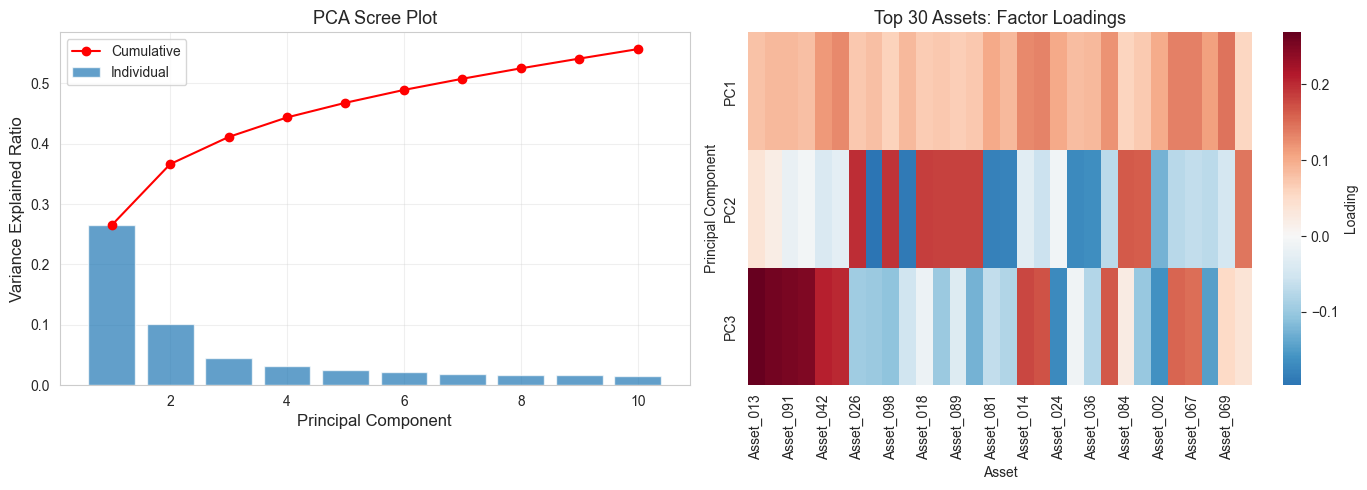


💡 INSIGHT: PC1 (market factor) explains 26.5% of variance.
   Remaining components likely represent sector/style factors.
   Assets with high PC2/PC3 loadings may offer diversification.


In [13]:
# Perform PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.fillna(0))

pca = PCA(n_components=10)
pca.fit(returns_scaled)

# Variance explained
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"\n📊 Factor Structure:")
for i in range(5):
    print(f"   PC{i+1}: {var_exp[i]*100:.1f}% variance explained")

print(f"\n   First 3 components explain {cum_var_exp[2]*100:.1f}% of total variance")

# Plot scree and loadings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 11), var_exp, alpha=0.7, label='Individual')
axes[0].plot(range(1, 11), cum_var_exp, 'ro-', label='Cumulative')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor loadings heatmap (top 3 factors, top 30 assets)
loadings = pca.components_[:3, :].T
loading_df = pd.DataFrame(loadings, index=returns.columns, columns=['PC1', 'PC2', 'PC3'])
loading_df['abs_max'] = loading_df.abs().max(axis=1)
top_loaded = loading_df.nlargest(30, 'abs_max')[['PC1', 'PC2', 'PC3']]

sns.heatmap(top_loaded.T, cmap='RdBu_r', center=0, cbar_kws={'label': 'Loading'}, ax=axes[1])
axes[1].set_title('Top 30 Assets: Factor Loadings', fontsize=13)
axes[1].set_xlabel('Asset')
axes[1].set_ylabel('Principal Component')

plt.tight_layout()
plt.savefig('leadlag_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: PC1 (market factor) explains {var_exp[0]*100:.1f}% of variance.")
print(f"   Remaining components likely represent sector/style factors.")
print(f"   Assets with high PC2/PC3 loadings may offer diversification.")

## 8. INTEGRATION PROPOSAL: StatArb Overlay Strategy

### Current Strategy Recap
- Ridge regression for alpha prediction
- Random Forest meta-labeling for confidence
- 20-day rebalancing, 3x leverage
- Market-neutral long/short

### Proposed StatArb Integration

#### Approach 1: Pair-Wise Overlay (Conservative)
**Mechanism:**
1. Identify top 5-10 cointegrated pairs
2. Track z-score of each spread
3. When |z| > 2: Enter pair trade (10% of portfolio per pair)
4. Exit when z reverts to 0

**Mathematical Framework:**
```
For pair (A, B):
- Spread_t = Price_A - β × Price_B  (β from OLS)
- Z_t = (Spread_t - μ_20d) / σ_20d

Position sizing:
- Long A, Short B when Z < -2: Position = -Z × 0.1 × Capital / 2
- Short A, Long B when Z > 2:  Position = Z × 0.1 × Capital / 2

Risk controls:
- Max 5 pairs active simultaneously
- Stop loss at |Z| > 4 (runaway spread)
- Recheck cointegration monthly
```